# Actividad :  Resolución de problema mediante búsqueda heurística





## Importante

El código siguiente es el que debe usarse para la ejecución de la actividad.
En caso de requerir modificaciones se subirán ficheros de sustitución al aula de la asignatura


In [231]:
!pip install simpleai flask pydot graphviz
import matplotlib.pyplot as plt
import networkx as nx

In [232]:
#!/usr/bin/env python
# coding: utf-8

# 2024 Modified by: Alejandro Cervantes
# Remember installing pyplot and flask if you want to use WebViewer

# NOTA: WebViewer sólo funcionará si ejecutáis en modo local

from __future__ import print_function

import math
from simpleai.search.viewers import BaseViewer,ConsoleViewer,WebViewer
from simpleai.search import SearchProblem, astar, breadth_first, depth_first, uniform_cost

node_count = 0
nodes = []
edges = []
depth_count = 1

class Node():
    
    def __init__(self, node_count, father_node_point, point_x, point_y, depht, action, heuristic_number):
        self.node_count = node_count
        self.father_node_point = father_node_point
        self.point = (point_x, point_y)
        self.depht = depht
        self.action = action
        self.heuristic_number = heuristic_number
        if (self.point == (3, 3)):
            self.identifier = "T"
        elif (self.point == (5, 1)):
            self.identifier = "P"
        else:
            self.identifier = f"n{node_count}_d{depht}_{self.point}_{action}"
            # lineas = [f"n:{node_count}", f"d:{depht}", f"p:{self.point}", f"a:{action}"]
            # self.identifier = "\n".join(lineas)

class GameWalkPuzzle(SearchProblem):

    def __init__(self, board, costs, heuristic_number):
        global node_count, nodes  
        self.board = board
        self.goal = (0, 0)
        self.costs = costs
        self.heuristic_number = heuristic_number
        for y in range(len(self.board)):
            for x in range(len(self.board[y])):
                if self.board[y][x].lower() == "t":
                    self.initial = (x, y)
                    node_count += 1
                    node = Node(  
                      node_count=node_count,
                      father_node_point=(3, 3),
                      point_x=x,
                      point_y=y,
                      depht=0,
                      action="no action",
                      heuristic_number=heuristic_number
                    )
                    nodes.append(node)
                elif self.board[y][x].lower() == "p":
                    self.goal = (x, y)

        super(GameWalkPuzzle, self).__init__(initial_state=self.initial)

    def actions(self, state):
        global node_count, nodes, depth_count, edges
        x, y = state
        actions = []
        for action in list(self.costs.keys()):
            newx, newy = self.result(state, action)
            if self.board[newy][newx] != "#":
                node_count = node_count + 1
                actions.append(action)
                new_node = Node(
                    node_count=node_count,
                    father_node_point=(x, y),
                    point_x=newx,
                    point_y=newy,
                    depht=depth_count,
                    action=action,
                    heuristic_number=1
                )
                '''
                is_visited_before = False
                for node in nodes:
                    if (node.point == (newx, newy)):
                        is_visited_before = True
                if not is_visited_before:
                    node_father = [n for n in nodes if n.point == (x, y)][0]
                    if node_father is not None:
                        edges.append((node_father.identifier, new_node.identifier))
                '''
                node_father = [n for n in nodes if n.point == (x, y)][0]
                fathers = [n for n in nodes if n.point == (x, y)]
                if len(fathers) > 1:
                    print(f"Hay más de un padre")
                    print(f"New node P:({new_node.point})")
                    for father in fathers:
                        print(f"Father P:({father.identifier})")
                # edges.append((node_father.identifier, new_node.identifier)"})
                edges.append((node_father.identifier, new_node.identifier, {"cost": f"{self.costs[action]}"}))
                nodes.append(new_node)
                
        depth_count = depth_count + 1
        return actions

    def result(self, state, action):
        x, y = state

        if action.count("up"):
            y -= 1
        if action.count("down"):
            y += 1
        if action.count("left"):
            x -= 1
        if action.count("right"):
            x += 1

        new_state = (x, y)
        return new_state

    def is_goal(self, state):
        return state == self.goal

    def cost(self, state, action, state2):
        return self.costs[action]

    # Esta función heurística es la distancia entre el estado actual
    # el objetivo (único) identificado como self.goal
    def heuristic1(self, state):
        x, y = state
        gx, gy = self.goal
        return abs(x - gx) + abs(y - gy)

    def heuristic2(self, state):
        x, y = state
        gx, gy = self.goal
        return max(abs(x - gx),abs(y - gy))

    def heuristic3(self, state):
        x, y = state
        gx, gy = self.goal
        return 2*(abs(x - gx) + abs(y - gy))

    def heuristic(self,state):
      if self.heuristic_number == 1:
          return self.heuristic1(state)
      elif self.heuristic_number == 2:
          return self.heuristic2(state)
      elif self.heuristic_number == 3:
          return self.heuristic3(state)
      else:
        raise Exception("El número de la función heurística debe estar entre 1 y 3. Revise la inicialización del problema.")

def searchInfo (problem,result,use_viewer):
    def getTotalCost (problem,result):
        originState = problem.initial_state
        totalCost = 0
        for action,endingState in result.path():
            if action is not None:
                totalCost += problem.cost(originState,action,endingState)
                originState = endingState
        return totalCost


    res = "Total length of solution: {0}\n".format(len(result.path()))
    res += "Total cost of solution: {0}\n".format(getTotalCost(problem,result))

    if use_viewer:
        stats = [{'name': stat.replace('_', ' '), 'value': value}
                         for stat, value in list(use_viewer.stats.items())]

        for s in stats:
            res+= '{0}: {1}\n'.format(s['name'],s['value'])
    return res


def resultado_experimento(problem,MAP,result,used_viewer):
    path = [x[1] for x in result.path()]

    for y in range(len(MAP)):
        for x in range(len(MAP[y])):
            if (x, y) == problem.initial:
                print("T", end='')
            elif (x, y) == problem.goal:
                print("P", end='')
            elif (x, y) in path:
                print("·", end='')
            else:
                print(MAP[y][x], end='')
        print()

    info = searchInfo(problem, result, used_viewer)
    print(info)

def main(MAP_ASCII,COSTS,algorithms,heuristic_number=1):
    MAP = [list(x) for x in MAP_ASCII.split("\n") if x]
    node_count = 0

    for algorithm in algorithms:
      problem = GameWalkPuzzle(MAP,COSTS,heuristic_number)
      used_viewer=BaseViewer()
      # Probad también ConsoleViewer para depurar
      # No podréis usar WebViewer en Collab para ver los árboles

      # Mostramos tres experimentos
      print ("Experimento con algoritmo {}:".format(algorithm))

      result = algorithm(problem, graph_search=True,viewer=used_viewer)
      resultado_experimento(problem,MAP,result,used_viewer)

## Busqueda en profundidad y anchura con mismo coste

Experimento con algoritmo <function breadth_first at 0x000001B936EF9620>:
Hay más de un padre
New node P:((5, 4))
Father P:(n15_d6_(5, 5)_right)
Father P:(n17_d7_(5, 5)_down)
Hay más de un padre
New node P:((6, 5))
Father P:(n15_d6_(5, 5)_right)
Father P:(n17_d7_(5, 5)_down)
Hay más de un padre
New node P:((4, 5))
Father P:(n15_d6_(5, 5)_right)
Father P:(n17_d7_(5, 5)_down)
Hay más de un padre
New node P:((6, 4))
Father P:(n25_d10_(6, 5)_right)
Father P:(n30_d12_(6, 5)_down)
Hay más de un padre
New node P:((5, 5))
Father P:(n25_d10_(6, 5)_right)
Father P:(n30_d12_(6, 5)_down)
Hay más de un padre
New node P:((3, 5))
Father P:(n28_d11_(2, 5)_left)
Father P:(n35_d14_(2, 5)_right)
Hay más de un padre
New node P:((1, 5))
Father P:(n28_d11_(2, 5)_left)
Father P:(n35_d14_(2, 5)_right)
########
#    P·#
# ####·#
#  T·#·#
# ##···#
#      #
########
Total length of solution: 9
Total cost of solution: 8.0
max fringe size: 5
visited nodes: 23
iterations: 23

50
48
('T', 'n2_d1_(4, 3)_right', {'cos

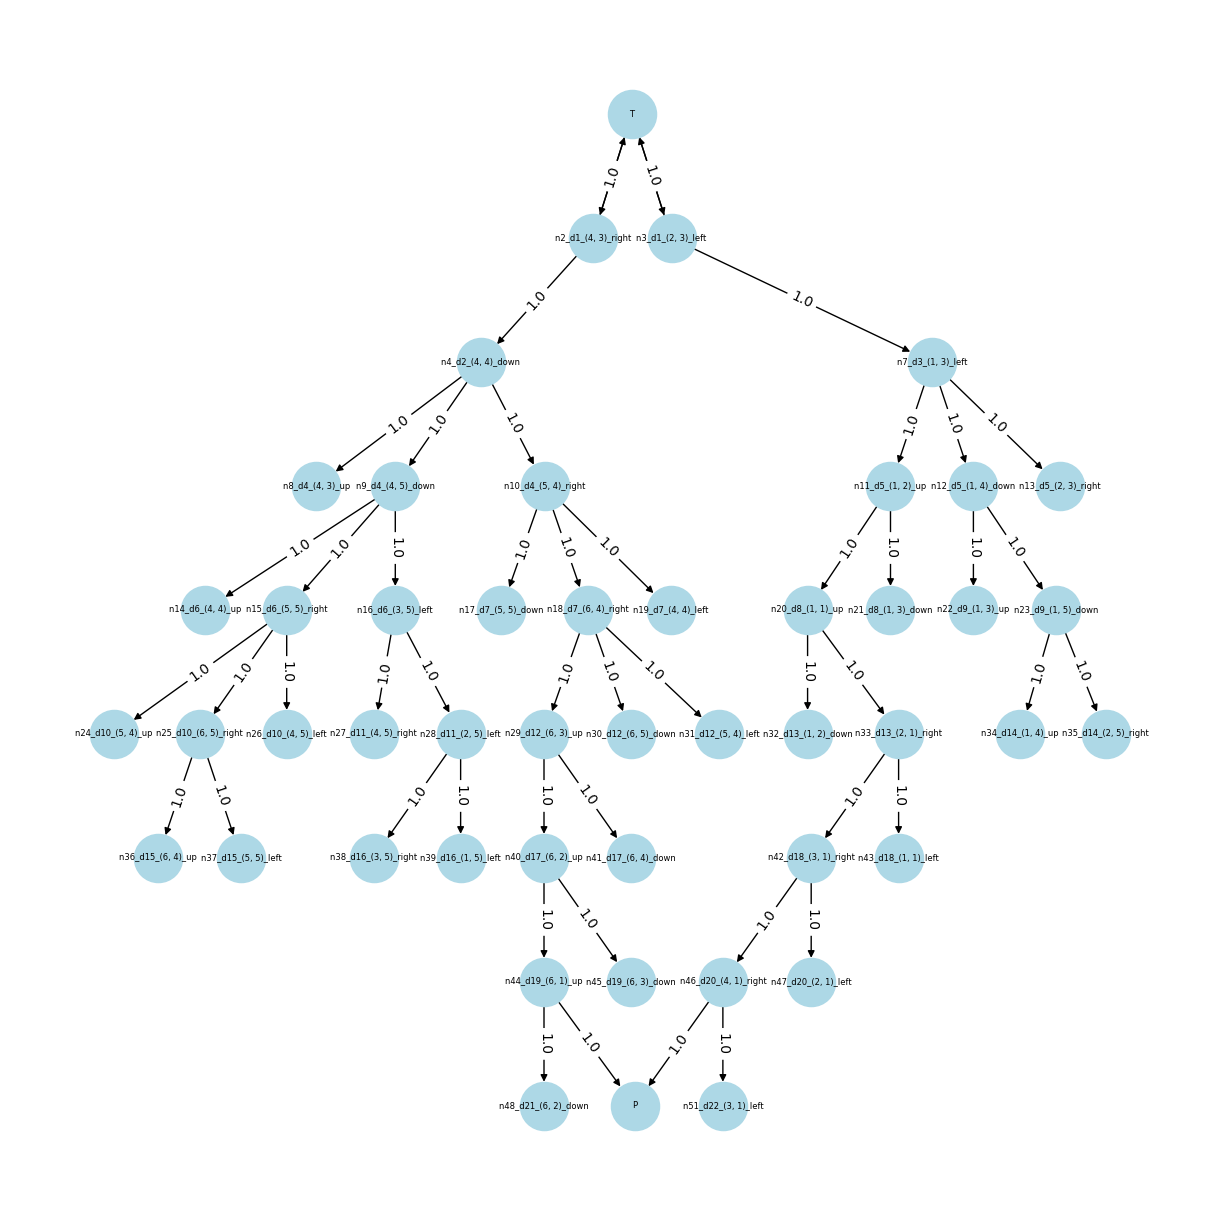

In [233]:
#!/usr/bin/env python
# coding: utf-8

# 2024 Modified by: Alejandro Cervantes
# Configuración y llamada para el caso 1
# Se ejecutan los algoritmos de búsqueda en amplitud y búsqueda en profundidad

MAP_ASCII = """
########
#    P #
# #### #
#  T # #
# ##   #
#      #
########
"""

COSTS = {
    "up": 1.0,
    "down": 1.0,
    "right": 1.0,
    "left": 1.0,
}

node_count = 0
nodes = []
edges = []
depth_count = 1

# algorithms=(breadth_first, depth_first)
algorithms=(breadth_first,)
main (MAP_ASCII, COSTS, algorithms)

# Crear un grafo tipo árbol
G = nx.DiGraph()

print(len(edges))
unique_y = {tup[1] for tup in edges}
print(len(unique_y))

G.add_edges_from(edges)

for edge in edges:
    print(edge)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=1200, node_color="lightblue", font_size=6)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Mostrar el árbol
plt.show()

Experimento con algoritmo <function depth_first at 0x000001B936EFAA20>:
########
#    P·#
# ####·#
#··T #·#
#·##  ·#
#······#
########
Total length of solution: 15
Total cost of solution: 14.0
max fringe size: 5
visited nodes: 15
iterations: 15



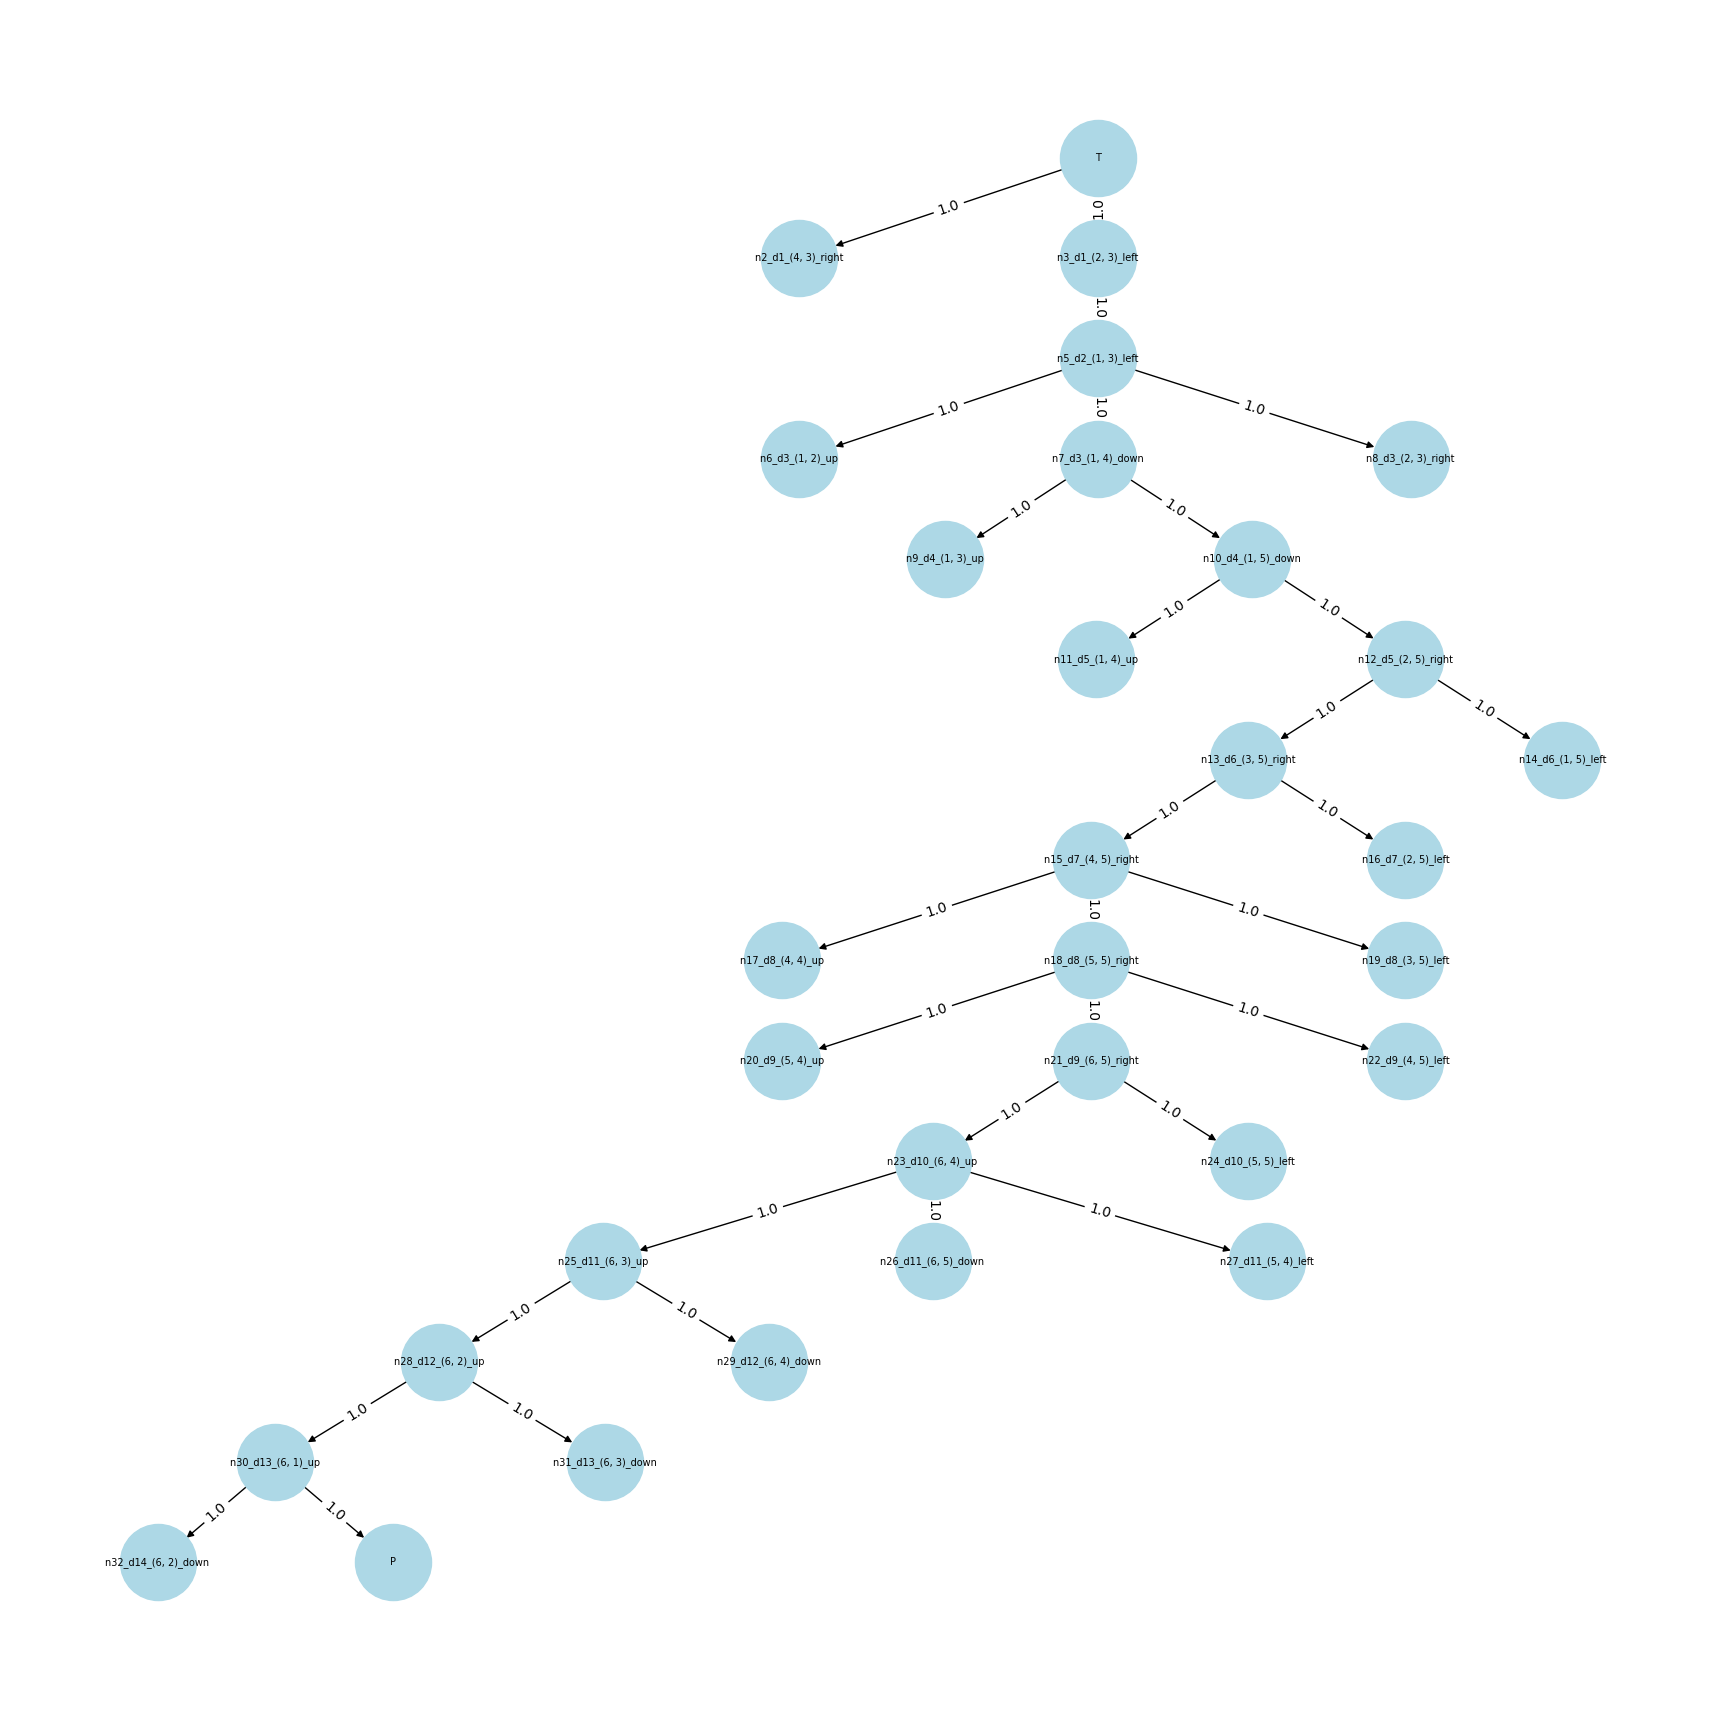

In [234]:
#!/usr/bin/env python
# coding: utf-8

# 2024 Modified by: Alejandro Cervantes
# Configuración y llamada para el caso 1
# Se ejecutan los algoritmos de búsqueda en amplitud y búsqueda en profundidad

MAP_ASCII = """
########
#    P #
# #### #
#  T # #
# ##   #
#      #
########
"""

node_count = 0
nodes = []
edges = []
depth_count = 1

COSTS = {
    "up": 1.0,
    "down": 1.0,
    "right": 1.0,
    "left": 1.0,
}

algorithms=(depth_first,)
main (MAP_ASCII, COSTS, algorithms)

# Crear un grafo tipo árbol
G = nx.DiGraph()

G.add_edges_from(edges)

# for edge in edges:
#     print(edge)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(17, 17))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=3000, node_color="lightblue", font_size=7)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Mostrar el árbol
plt.show()

## Busqueda en anchura, coste uniforme y A* con coste diferente

Experimento con algoritmo <function breadth_first at 0x000001B936EF9620>:
Hay más de un padre
New node P:((5, 4))
Father P:(n15_d6_(5, 5)_right)
Father P:(n17_d7_(5, 5)_down)
Hay más de un padre
New node P:((6, 5))
Father P:(n15_d6_(5, 5)_right)
Father P:(n17_d7_(5, 5)_down)
Hay más de un padre
New node P:((4, 5))
Father P:(n15_d6_(5, 5)_right)
Father P:(n17_d7_(5, 5)_down)
Hay más de un padre
New node P:((6, 4))
Father P:(n25_d10_(6, 5)_right)
Father P:(n30_d12_(6, 5)_down)
Hay más de un padre
New node P:((5, 5))
Father P:(n25_d10_(6, 5)_right)
Father P:(n30_d12_(6, 5)_down)
Hay más de un padre
New node P:((3, 5))
Father P:(n28_d11_(2, 5)_left)
Father P:(n35_d14_(2, 5)_right)
Hay más de un padre
New node P:((1, 5))
Father P:(n28_d11_(2, 5)_left)
Father P:(n35_d14_(2, 5)_right)
########
#    P·#
# ####·#
#  T·#·#
# ##···#
#      #
########
Total length of solution: 9
Total cost of solution: 28.0
max fringe size: 5
visited nodes: 23
iterations: 23



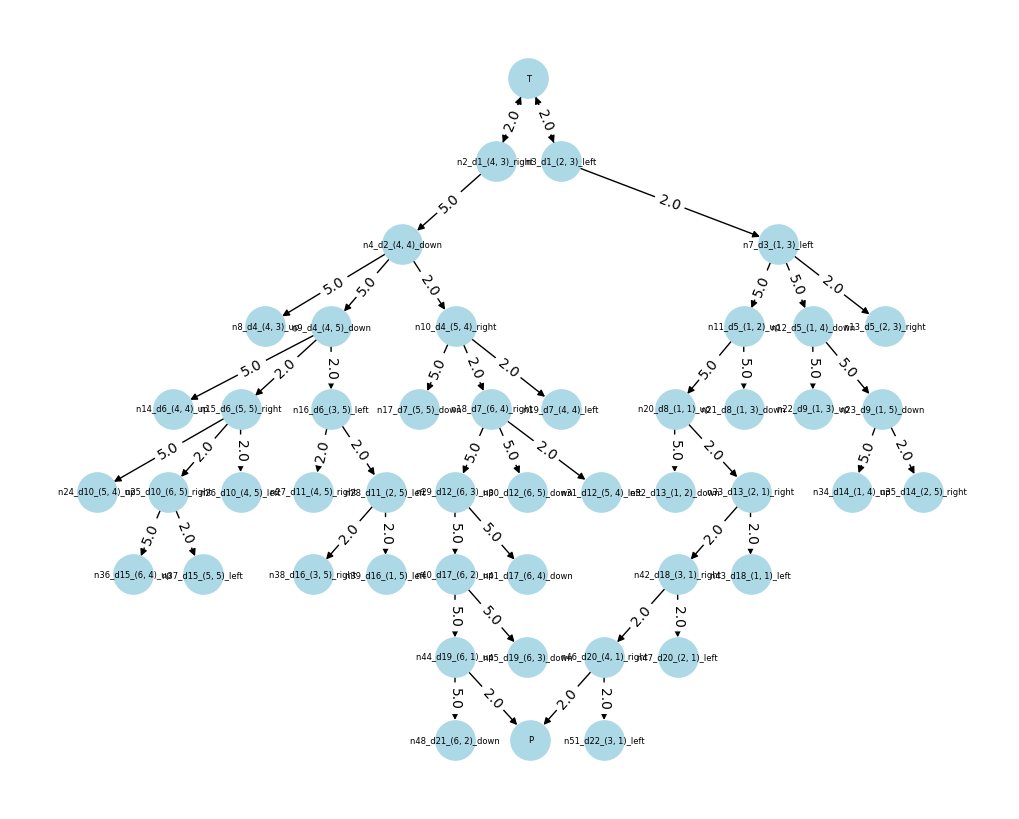

In [235]:
#!/usr/bin/env python
# coding: utf-8

# 2024 Modified by: Alejandro Cervantes
# Configuración y llamada para el caso 2
# Se utiliza el mismo mapa pero se varían los costes

MAP_ASCII = """
########
#    P #
# #### #
#  T # #
# ##   #
#      #
########
"""

COSTS = {
    "up": 5.0,
    "down": 5.0,
    "right": 2.0,
    "left": 2.0,
}

node_count = 0
nodes = []
edges = []
depth_count = 1

algorithms=(breadth_first,)
main (MAP_ASCII, COSTS, algorithms)

# Crear un grafo tipo árbol
G = nx.DiGraph()

G.add_edges_from(edges)

# for edge in edges:
#     print(edge)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color="lightblue", font_size=6)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Mostrar el árbol
plt.show()

Experimento con algoritmo <function uniform_cost at 0x000001B936EFB880>:
Hay más de un padre
New node P:((5, 4))
Father P:(n18_d8_(5, 5)_down)
Father P:(n25_d10_(5, 5)_right)
Hay más de un padre
New node P:((6, 5))
Father P:(n18_d8_(5, 5)_down)
Father P:(n25_d10_(5, 5)_right)
Hay más de un padre
New node P:((4, 5))
Father P:(n18_d8_(5, 5)_down)
Father P:(n25_d10_(5, 5)_right)
Hay más de un padre
New node P:((6, 4))
Father P:(n22_d9_(6, 5)_down)
Father P:(n32_d13_(6, 5)_right)
Hay más de un padre
New node P:((5, 5))
Father P:(n22_d9_(6, 5)_down)
Father P:(n32_d13_(6, 5)_right)
Hay más de un padre
New node P:((3, 5))
Father P:(n28_d11_(2, 5)_right)
Father P:(n30_d12_(2, 5)_left)
Hay más de un padre
New node P:((1, 5))
Father P:(n28_d11_(2, 5)_right)
Father P:(n30_d12_(2, 5)_left)
########
#····P #
#·#### #
#··T # #
# ##   #
#      #
########
Total length of solution: 9
Total cost of solution: 22.0
max fringe size: 6
visited nodes: 22
iterations: 22



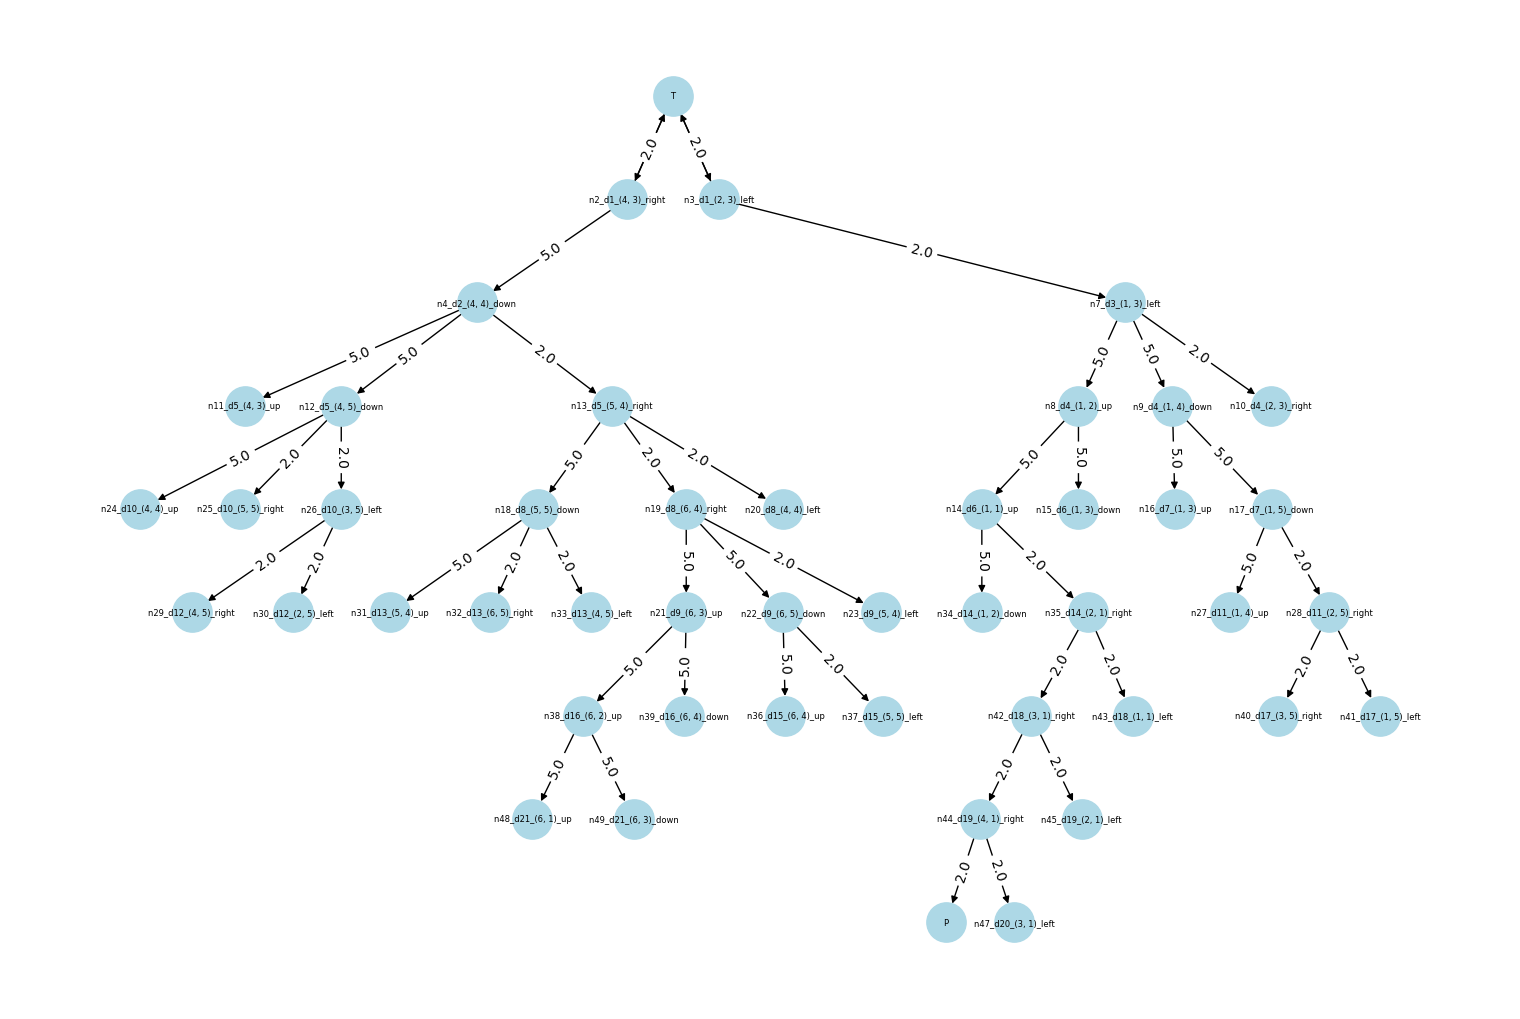

In [236]:
#!/usr/bin/env python
# coding: utf-8

# 2024 Modified by: Alejandro Cervantes
# Configuración y llamada para el caso 2
# Se utiliza el mismo mapa pero se varían los costes

MAP_ASCII = """
########
#    P #
# #### #
#  T # #
# ##   #
#      #
########
"""

COSTS = {
    "up": 5.0,
    "down": 5.0,
    "right": 2.0,
    "left": 2.0,
}

node_count = 0
nodes = []
edges = []
depth_count = 1

algorithms=(uniform_cost,)
main (MAP_ASCII, COSTS, algorithms)

# Crear un grafo tipo árbol
G = nx.DiGraph()

G.add_edges_from(edges)

# for edge in edges:
#     print(edge)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color="lightblue", font_size=6)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Mostrar el árbol
plt.show()

Experimento con algoritmo <function astar at 0x000001B936EFB9C0>:
Hay más de un padre
New node P:((5, 4))
Father P:(n14_d6_(5, 5)_down)
Father P:(n25_d10_(5, 5)_right)
Hay más de un padre
New node P:((6, 5))
Father P:(n14_d6_(5, 5)_down)
Father P:(n25_d10_(5, 5)_right)
Hay más de un padre
New node P:((4, 5))
Father P:(n14_d6_(5, 5)_down)
Father P:(n25_d10_(5, 5)_right)
Hay más de un padre
New node P:((6, 4))
Father P:(n20_d8_(6, 5)_down)
Father P:(n28_d11_(6, 5)_right)
Hay más de un padre
New node P:((5, 5))
Father P:(n20_d8_(6, 5)_down)
Father P:(n28_d11_(6, 5)_right)
########
#····P #
#·#### #
#··T # #
# ##   #
#      #
########
Total length of solution: 9
Total cost of solution: 22.0
max fringe size: 6
visited nodes: 20
iterations: 20



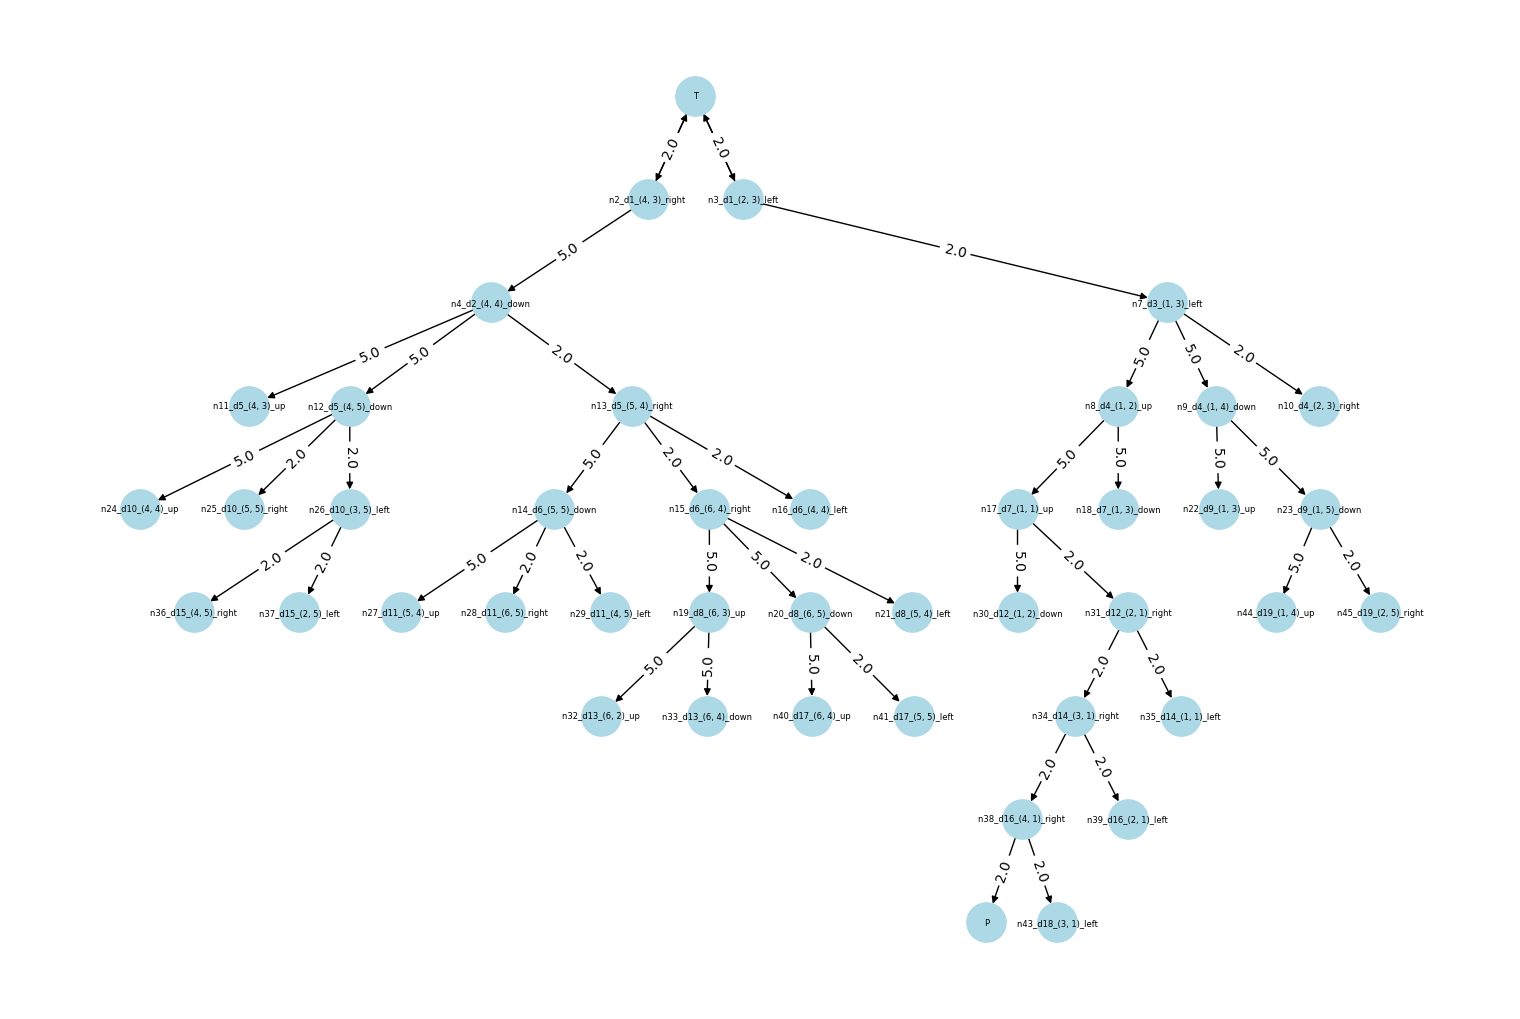

In [237]:
#!/usr/bin/env python
# coding: utf-8

# 2024 Modified by: Alejandro Cervantes
# Configuración y llamada para el caso 2
# Se utiliza el mismo mapa pero se varían los costes

MAP_ASCII = """
########
#    P #
# #### #
#  T # #
# ##   #
#      #
########
"""

COSTS = {
    "up": 5.0,
    "down": 5.0,
    "right": 2.0,
    "left": 2.0,
}

node_count = 0
nodes = []
edges = []
depth_count = 1

algorithms=(astar,)
main (MAP_ASCII, COSTS, algorithms)

# Crear un grafo tipo árbol
G = nx.DiGraph()

G.add_edges_from(edges)

# for edge in edges:
#     print(edge)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color="lightblue", font_size=6)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Mostrar el árbol
plt.show()

## A* diferentes heurísticas

Experimento con algoritmo <function astar at 0x000001B936EFB9C0>:
Hay más de un padre
New node P:((5, 4))
Father P:(n11_d5_(5, 5)_down)
Father P:(n15_d6_(5, 5)_right)
Hay más de un padre
New node P:((6, 5))
Father P:(n11_d5_(5, 5)_down)
Father P:(n15_d6_(5, 5)_right)
Hay más de un padre
New node P:((4, 5))
Father P:(n11_d5_(5, 5)_down)
Father P:(n15_d6_(5, 5)_right)
########
#    P·#
# ####·#
#  T·#·#
# ##···#
#      #
########
Total length of solution: 9
Total cost of solution: 8.0
max fringe size: 5
visited nodes: 16
iterations: 16



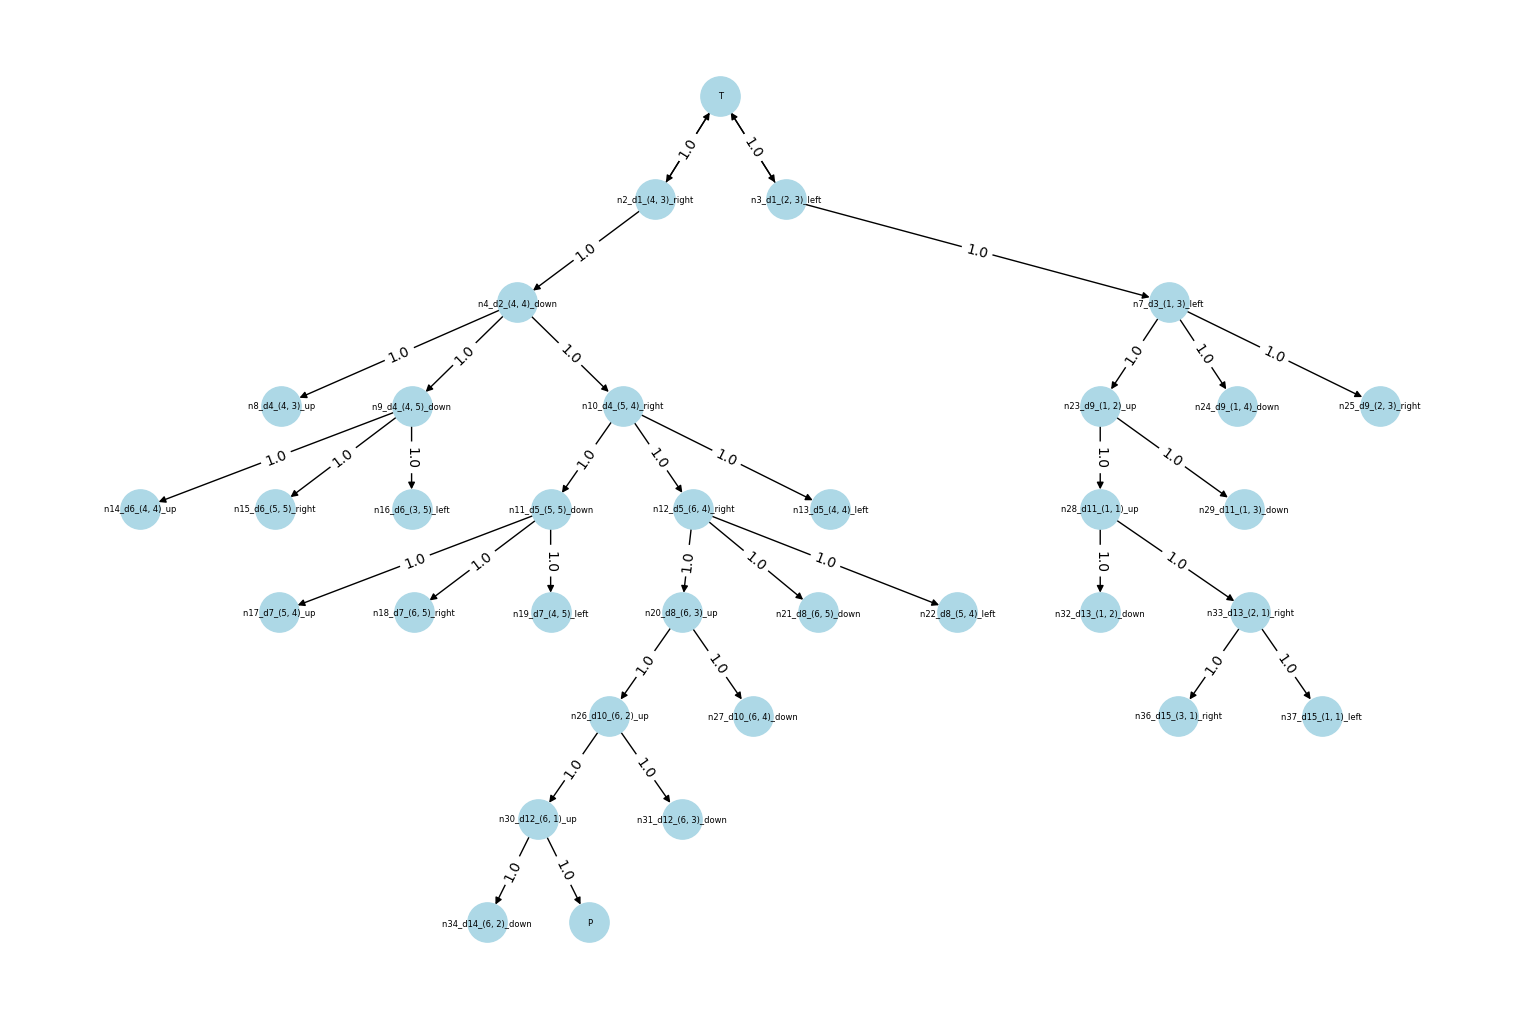

In [238]:
#!/usr/bin/env python
# coding: utf-8

# 2024 Modified by: Alejandro Cervantes
# Configuración y llamada para el caso 3
# Se utiliza el mismo mapa y se usan diferentes heurísticas

MAP_ASCII = """
########
#    P #
# #### #
#  T # #
# ##   #
#      #
########
"""

COSTS = {
    "up": 1.0,
    "down": 1.0,
    "right": 1.0,
    "left": 1.0,
}

node_count = 0
nodes = []
edges = []
depth_count = 1

algorithms=(astar,)
main (MAP_ASCII,COSTS,algorithms,1)

# Crear un grafo tipo árbol
G = nx.DiGraph()

G.add_edges_from(edges)

# for edge in edges:
#     print(edge)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color="lightblue", font_size=6)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Mostrar el árbol
plt.show()

Experimento con algoritmo <function astar at 0x000001B936EFB9C0>:
########
#    P·#
# ####·#
#  T·#·#
# ##···#
#      #
########
Total length of solution: 9
Total cost of solution: 8.0
max fringe size: 6
visited nodes: 17
iterations: 17



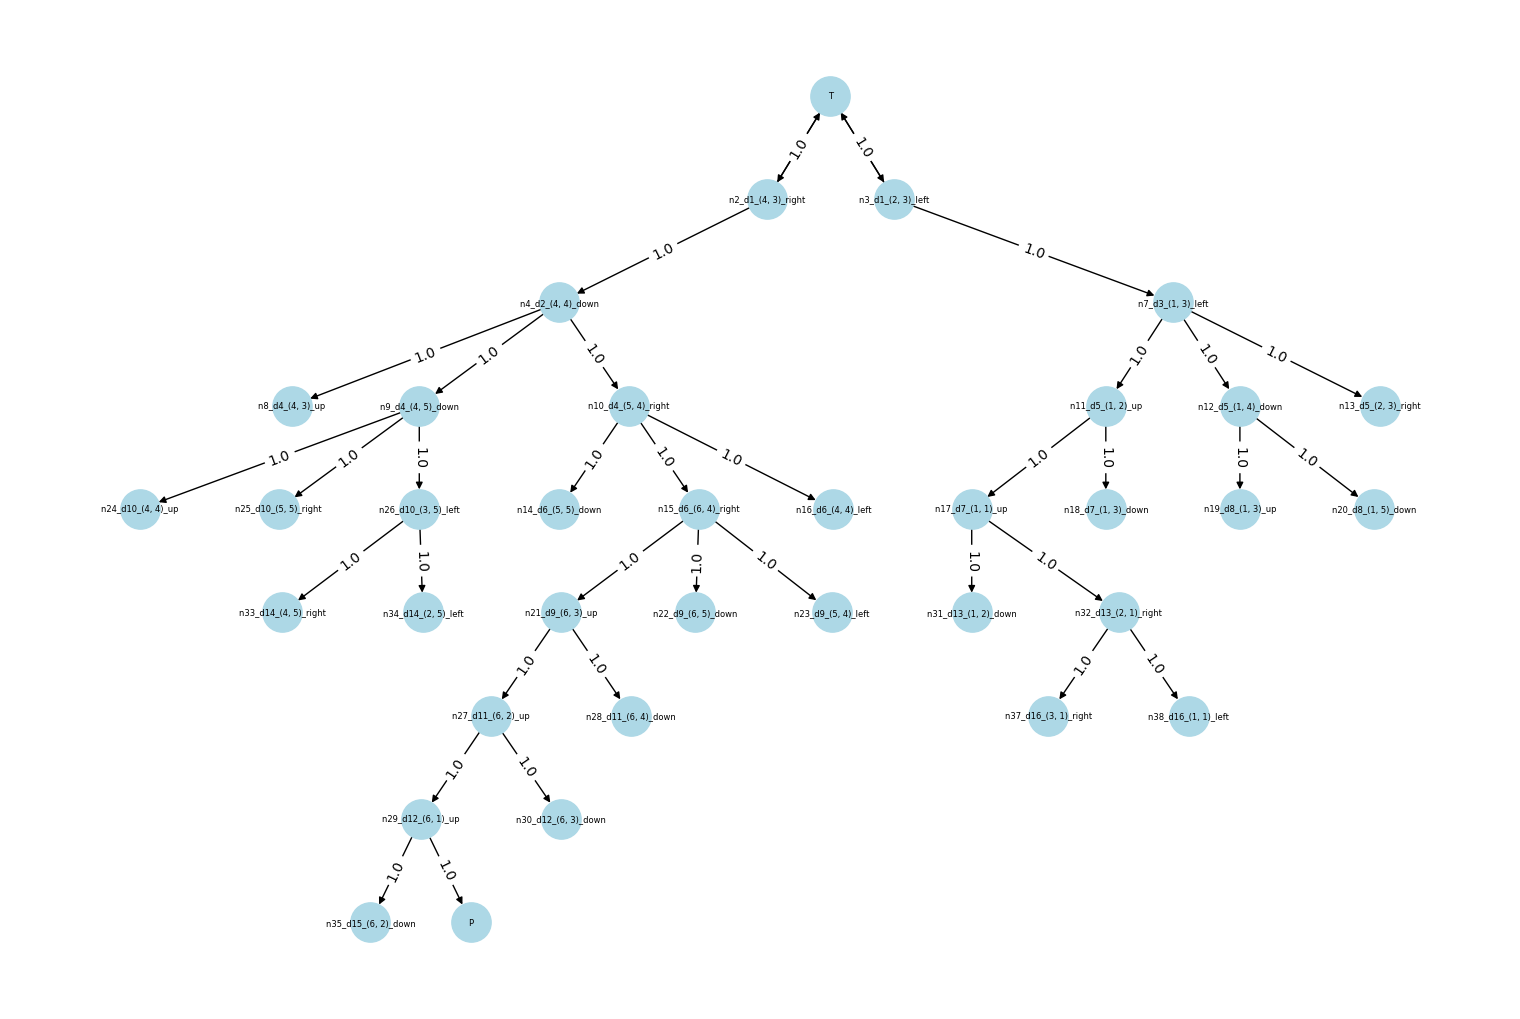

In [239]:
node_count = 0
nodes = []
edges = []
depth_count = 1

main (MAP_ASCII,COSTS,algorithms,2)

# Crear un grafo tipo árbol
G = nx.DiGraph()

G.add_edges_from(edges)

# for edge in edges:
#     print(edge)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color="lightblue", font_size=6)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Mostrar el árbol
plt.show()

Experimento con algoritmo <function astar at 0x000001B936EFB9C0>:
########
#    P·#
# ####·#
#  T·#·#
# ##···#
#      #
########
Total length of solution: 9
Total cost of solution: 8.0
max fringe size: 4
visited nodes: 11
iterations: 11



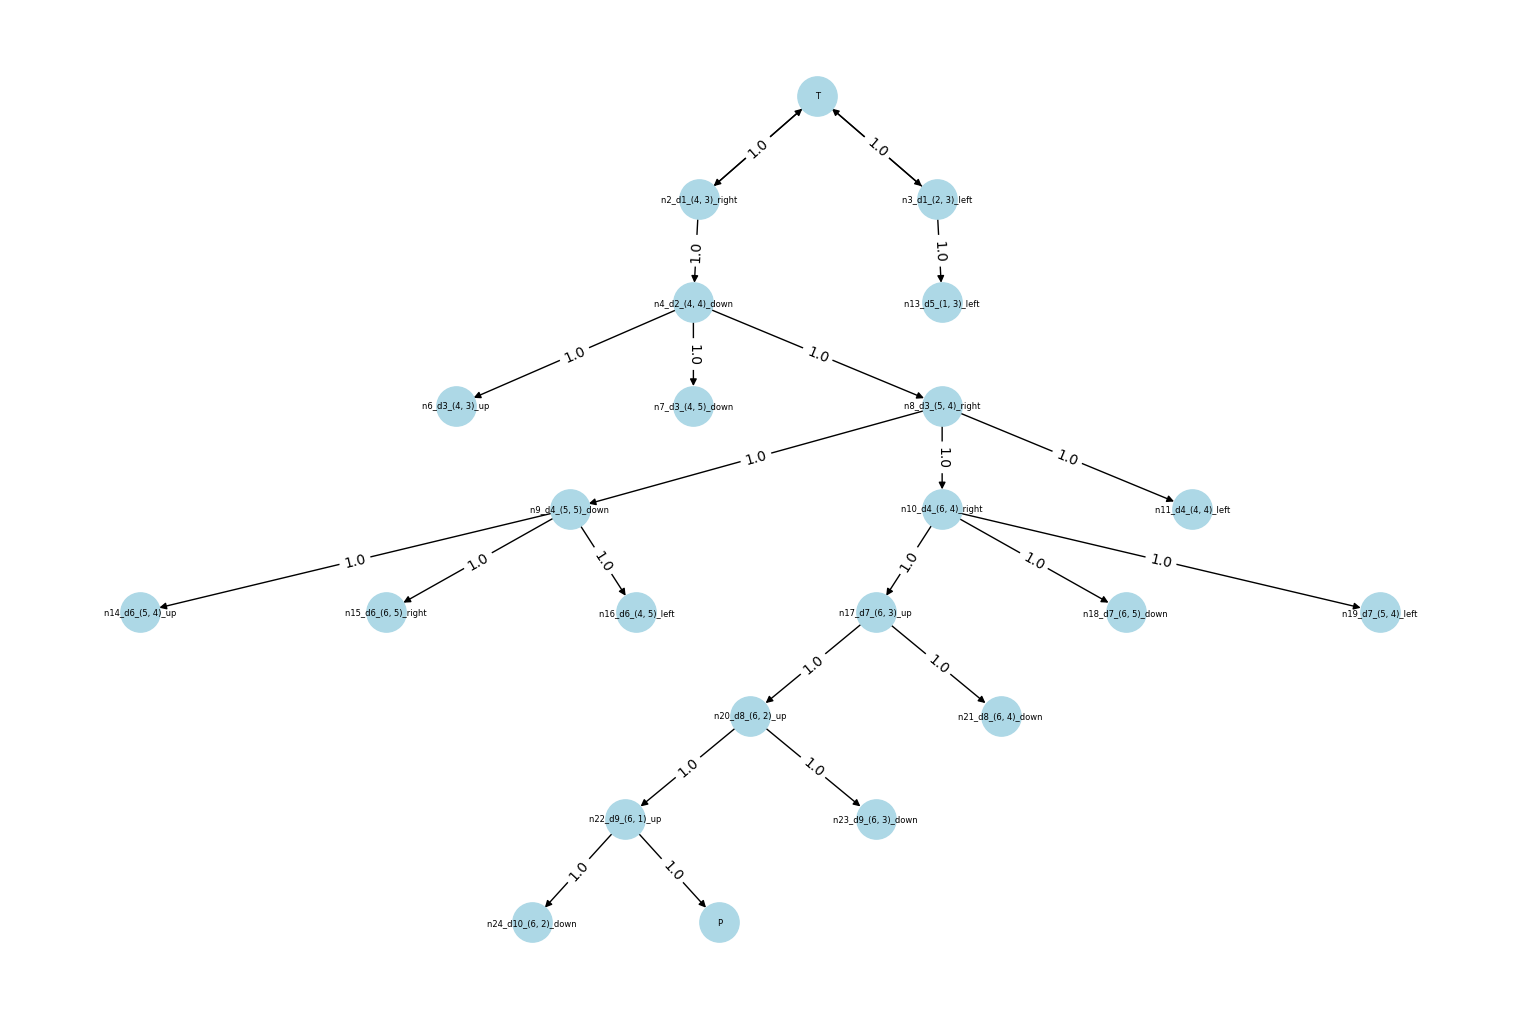

In [240]:
node_count = 0
nodes = []
edges = []
depth_count = 1

main (MAP_ASCII,COSTS,algorithms,3)

# Crear un grafo tipo árbol
G = nx.DiGraph()

G.add_edges_from(edges)

# for edge in edges:
#     print(edge)

# Dibujar el grafo con un diseño jerárquico
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Necesita Graphviz instalado
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color="lightblue", font_size=6)

# Get edge labels and draw them
edge_labels = nx.get_edge_attributes(G, "cost")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Mostrar el árbol
plt.show()